In [1]:
# Import packages
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import snapatac2 as snap
import scipy.stats as stats

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [17]:
# File paths
sample_metadata_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/metadata/2023_11_26/sample_metadata_26Nov23.tsv"
h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/merged.h5ads"
cellid_colors_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/26Nov23/cellid_colors.tsv"
condition_colors_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/26Nov23/condition_colors.tsv"
fig_dir = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/2024_01_20/condition_within_batch/ext4/snapatac2"

# Confirm they exist
assert os.path.exists(sample_metadata_path)
assert os.path.exists(h5ad_path)

# Make figure directory
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Params
umap_key = "X_umap"
embedding_key = "X_spectral"
cell_id_col = "integrated_manual_cellid_annotation"
num_pcs = 10

# Load and format data

In [3]:
# Load and inspect sample metadata
sample_metadata = pd.read_csv(sample_metadata_path, sep="\t")[['sample_id', 'sample_description', 'atac_library_id', 'rna_library_id','batch', 'timepoint', 'condition']]
sample_metadata.head()

,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
0,dm0b,0hr_control,WB_73,WB_74,A2,0,control
1,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
2,dm12b,6hr_IFNg,WB_75,WB_76,A2,6,IFNg
3,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
4,dm21a,24hr_3-cyt,WB_11,WB_12,A2,24,3-cyt


In [4]:
# Load cell id colors
cellid_colors = pd.read_csv(cellid_colors_path, sep="\t", index_col=0, header=None)
cellid_colors = cellid_colors.to_dict()[1]
cellid_colors

{'SC.beta': '#2a9df4',
 'SC.alpha': '#967bb6',
 'SC.EC': '#ff7f50',
 'SC.delta': '#dc143c',
 'proliferating_alpha': '#ff91a4',
 'other': '#708090'}

In [5]:
# Load in condition colors
condition_colors = pd.read_csv(condition_colors_path, delim_whitespace=True, index_col=0, header=None)
condition_colors = condition_colors.to_dict()[1]
condition_colors

{'control': '#B0B0B0',
 '3-cyt': '#FFA07A',
 'IFNg': '#FF7F50',
 'Ex-4_HG': '#90EE90',
 'palmitate': '#BA55D3',
 'dex': '#ADD8E6'}

In [6]:
# Read in h5ad file
adataset = snap.read_dataset(h5ad_path)
adata = adataset.to_adata()
adata

AnnData object with n_obs × n_vars = 33633 × 606219
    obs: 'sample', 'integrated_manual_cellid_annotation', 'leiden_1'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet'
    obsm: 'X_spectral', 'X_umap'
    obsp: 'distances'

In [7]:
# Change variable names
adata.obsm["X_umap"] = adata.obsm[umap_key]
adata.obsm["X_spectral"] = adata.obsm[embedding_key]
adata.obs["cell_id"] = adata.obs[cell_id_col]
adata

AnnData object with n_obs × n_vars = 33633 × 606219
    obs: 'sample', 'integrated_manual_cellid_annotation', 'leiden_1', 'cell_id'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet'
    obsm: 'X_spectral', 'X_umap'
    obsp: 'distances'

In [8]:
# Merge metadata
bcs = adata.obs.index.tolist()
adata_obs = adata.obs.merge(sample_metadata, left_on="sample", right_on="sample_id")
adata_obs.index = bcs
adata.obs = adata_obs
adata.obs.head()

,sample,integrated_manual_cellid_annotation,leiden_1,cell_id,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
dm14b#AAACAGCCAATAATCC-1,dm14b,SC.alpha,7,SC.alpha,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACAGCCACCTCAGG-1,dm14b,SC.beta,5,SC.beta,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACATGCATTTAAGC-1,dm14b,SC.EC,1,SC.EC,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACCAACAAACAACA-1,dm14b,SC.beta,7,SC.beta,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACCAACAGGCTTGT-1,dm14b,SC.EC,1,SC.EC,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG


In [9]:
# Merge embedding values
embeddings = pd.DataFrame(adata.obsm["X_spectral"][:, :10], columns=[f"spectral{i}" for i in range(1, 11)], index=adata.obs.index)
adata.obs = pd.concat([adata.obs, embeddings], axis=1)
adata.obs.head()

,sample,integrated_manual_cellid_annotation,leiden_1,cell_id,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,...,spectral1,spectral2,spectral3,spectral4,spectral5,spectral6,spectral7,spectral8,spectral9,spectral10
dm14b#AAACAGCCAATAATCC-1,dm14b,SC.alpha,7,SC.alpha,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,...,-0.004184,-0.001132,0.000520,-0.000625,-0.000021,3.336957e-05,-0.000177,0.000330,-0.000005,-0.000330
dm14b#AAACAGCCACCTCAGG-1,dm14b,SC.beta,5,SC.beta,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,...,-0.005874,-0.000027,0.000164,0.000041,0.000157,3.089661e-07,-0.000185,-0.000171,0.000022,-0.000170
dm14b#AAACATGCATTTAAGC-1,dm14b,SC.EC,1,SC.EC,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,...,-0.005140,-0.000336,0.000559,0.000232,0.000289,3.581881e-04,-0.000153,-0.000026,0.000019,-0.000189
dm14b#AAACCAACAAACAACA-1,dm14b,SC.beta,7,SC.beta,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,...,-0.006155,-0.001753,0.000776,-0.000131,0.000207,5.844923e-05,-0.000111,0.000241,-0.000225,-0.000375
dm14b#AAACCAACAGGCTTGT-1,dm14b,SC.EC,1,SC.EC,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,...,-0.005372,-0.000450,-0.000176,-0.000038,-0.000044,1.042086e-04,-0.000179,0.000110,0.000033,-0.000092


In [10]:
# Remove any colors that are not in the data
timepoint_categories = adata.obs["timepoint"].unique()
cellid_colors = {k: v for k, v in cellid_colors.items() if k in adata.obs["cell_id"].unique()}
condition_colors = {k: v for k, v in condition_colors.items() if k in adata.obs["condition"].unique()}

In [11]:
# Timepoint should be a categorical variable with a gradient of colors that increases from 0, 6, 24, 48, 72
adata.obs["timepoint"] = adata.obs["timepoint"].astype("category")
adata.obs["timepoint"] = adata.obs["timepoint"].cat.reorder_categories(timepoint_categories)
adata.uns["timepoint_colors"] = list(plt.get_cmap("Reds")(np.linspace(0, 1, len(timepoint_categories))))

# Cell id should be a categorical variable 
adata.obs["cell_id"] = adata.obs["cell_id"].astype("category")
adata.obs["cell_id"] = adata.obs["cell_id"].cat.reorder_categories(cellid_colors.keys())
adata.uns["cell_id_colors"] = cellid_colors.values()

# Condition should be a categorical variable
adata.obs["condition"] = adata.obs["condition"].astype("category")
adata.obs["condition"] = adata.obs["condition"].cat.reorder_categories(condition_colors.keys())
adata.uns["condition_colors"] = condition_colors.values()

# Calcluate correlations with embeddings

In [12]:
# Get ANOVA results for categorical variables
categorical_covariates = ["cell_id", "batch", "condition", "timepoint"]
pca_anova_df = dc.get_metadata_associations(
    data=[embeddings, adata.obs],
    obs_keys=categorical_covariates,
)
pca_anova_df["-log10(p_adj)"] = -np.log10(pca_anova_df["p_adj"])
pca_anova_df.head()

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:05,  1.70it/s]

 20%|██        | 2/10 [00:01<00:04,  1.61it/s]

 30%|███       | 3/10 [00:01<00:04,  1.58it/s]

 40%|████      | 4/10 [00:02<00:03,  1.57it/s]

 50%|█████     | 5/10 [00:03<00:03,  1.56it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.56it/s]

 70%|███████   | 7/10 [00:04<00:01,  1.56it/s]

 80%|████████  | 8/10 [00:05<00:01,  1.55it/s]

 90%|█████████ | 9/10 [00:05<00:00,  1.56it/s]

100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


,variable,pval,eta_sq,factor,p_adj,-log10(p_adj)
0,cell_id,1.635374e-49,0.007066,spectral1,NaN,NaN
1,batch,NaN,NaN,spectral1,NaN,NaN
2,condition,1.599473e-21,0.002696,spectral1,NaN,NaN
3,timepoint,0.000000e+00,0.097559,spectral1,NaN,NaN
4,cell_id,1.470531e-234,0.032043,spectral2,NaN,NaN


In [13]:
# Get log counts
adata.obs["log1p_total_counts"] = np.log1p(adata.X.sum(axis=1)+1)

In [14]:
# Spearman correlations between embeddings and continuous covariates
continuous_covariates = ["log1p_total_counts"]
pca_spearman_list = []
for pc in embeddings.columns:
    for cov in continuous_covariates:
        rho, p = stats.spearmanr(embeddings[pc], adata.obs[cov])
        pca_spearman_list.append([pc, cov, rho, p])
pca_spearman_df = pd.DataFrame(pca_spearman_list, columns=["dim", "covariate", "rho", "p"])
pca_spearman_df["-log10(p)"] = -np.log10(pca_spearman_df["p"])
pca_spearman_df.head()

/cellar/users/aklie/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,dim,covariate,rho,p,-log10(p)
0,spectral1,log1p_total_counts,-0.987498,0.000000e+00,inf
1,spectral2,log1p_total_counts,0.118741,7.304473e-106,105.136411
2,spectral3,log1p_total_counts,-0.342683,0.000000e+00,inf
3,spectral4,log1p_total_counts,-0.030400,2.459011e-08,7.609240
4,spectral5,log1p_total_counts,-0.043543,1.360982e-15,14.866148


In [18]:
# For the highest ANOVA eta_sq, plot a violinplot of the PCs vs the categorical variable
eta_sq_cutoff = 0.05
eta_sq_df = pca_anova_df[pca_anova_df["eta_sq"] > eta_sq_cutoff]

# Plot
for i, row in eta_sq_df.iterrows():
        fig, ax = plt.subplots(figsize=(10, 5))
        pc = row["factor"]
        cov = row["variable"]
        eta_sq = row["eta_sq"]
        sns.violinplot(
            x=cov,
            y=pc,
            data=adata.obs,
            ax=ax,
        )
        plt.title(f"{pc} vs {cov} (eta_sq={eta_sq:.2f})")
        plt.savefig(os.path.join(fig_dir, f"{pc}_vs_{cov}.png"), bbox_inches="tight")    
        plt.close()

2024-01-22 07:54:03 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-01-22 07:54:03 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-01-22 07:54:03 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-01-22 07:54:05 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-01-22 07:54:05 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-01-22 07:54:05 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-01-22 07:54:08 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-01-22 07:54:08 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

In [19]:
# For the highest spearman rho, plot a scatterplot of the PCs vs the continuous variable
rho_cutoff = 0.3
rho_df = pca_spearman_df[pca_spearman_df["rho"].abs() > rho_cutoff]

# Plot
for i, row in rho_df.iterrows():
        fig, ax = plt.subplots(figsize=(5, 5))
        pc = row["dim"]
        cov = row["covariate"]
        rho = row["rho"]
        sns.scatterplot(
            x=cov,
            y=pc,
            data=adata.obs,
            ax=ax,
        )
        plt.title(f"{pc} vs {cov} (rho={rho:.2f})")
        plt.savefig(os.path.join(fig_dir, f"{pc}_vs_{cov}.png"), bbox_inches="tight")    
        plt.close()

# Plot dimensionality reductions

... storing 'sample' as categorical
... storing 'integrated_manual_cellid_annotation' as categorical
... storing 'sample_id' as categorical
... storing 'sample_description' as categorical
... storing 'atac_library_id' as categorical
... storing 'rna_library_id' as categorical
... storing 'batch' as categorical
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


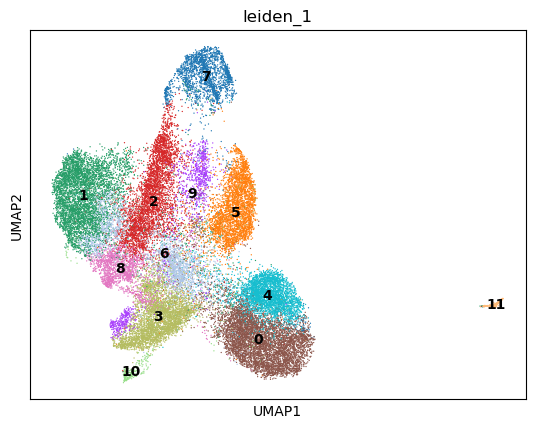

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


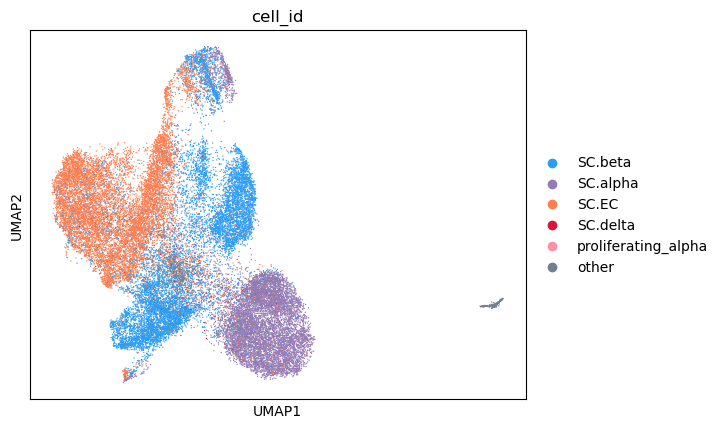

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


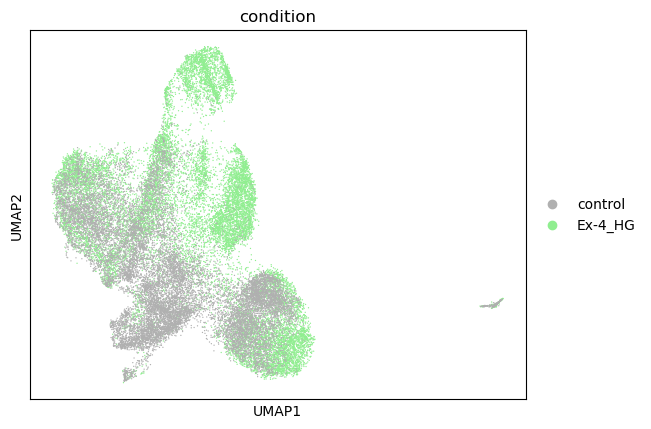

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


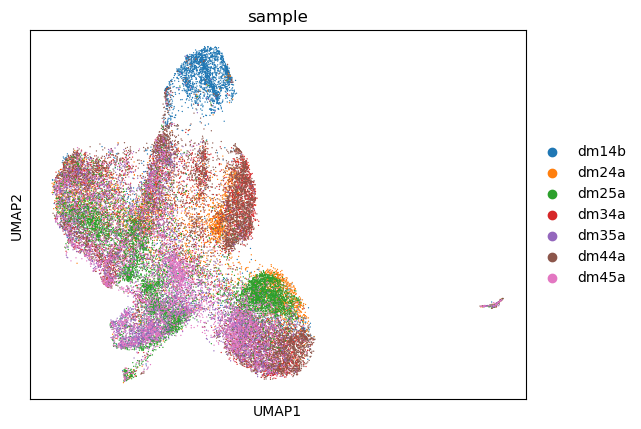

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1124: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


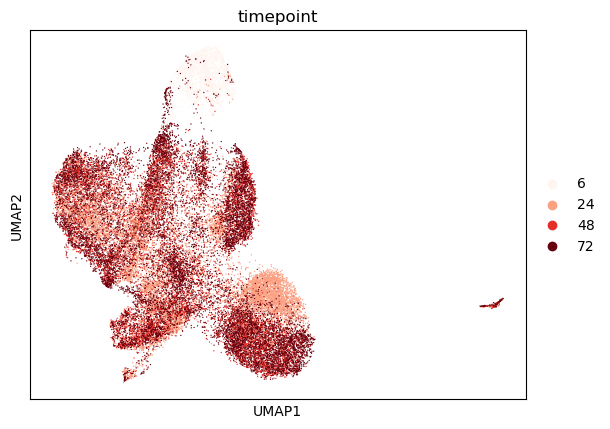

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


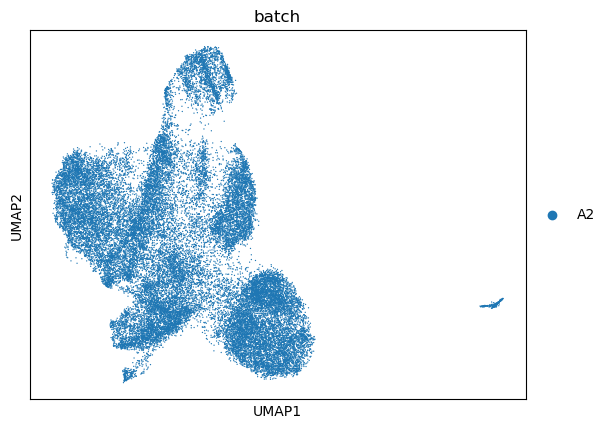

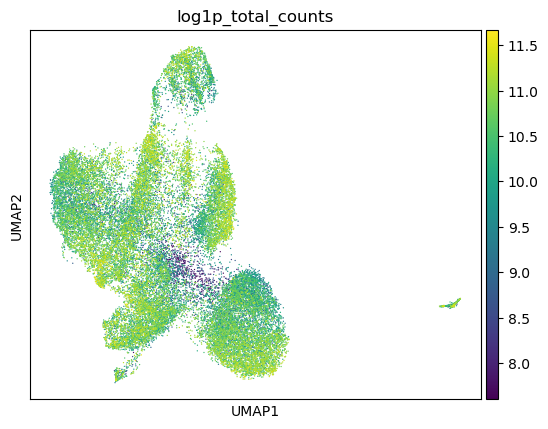

In [20]:
# Unsupervised clustering
sc.pl.umap(adata, color=['leiden_1'], legend_loc='on data')
sc.pl.umap(adata, color=['cell_id'])
sc.pl.umap(adata, color=['condition'])
sc.pl.umap(adata, color=['sample'])
sc.pl.umap(adata, color=['timepoint'])
sc.pl.umap(adata, color=['batch'])
sc.pl.umap(adata, color=['log1p_total_counts'])

In [23]:
adata_peaks

NameError: name 'adata_peaks' is not defined

Text(0.5, 1.0, 'Timepoint proportions in leiden_1 clusters')

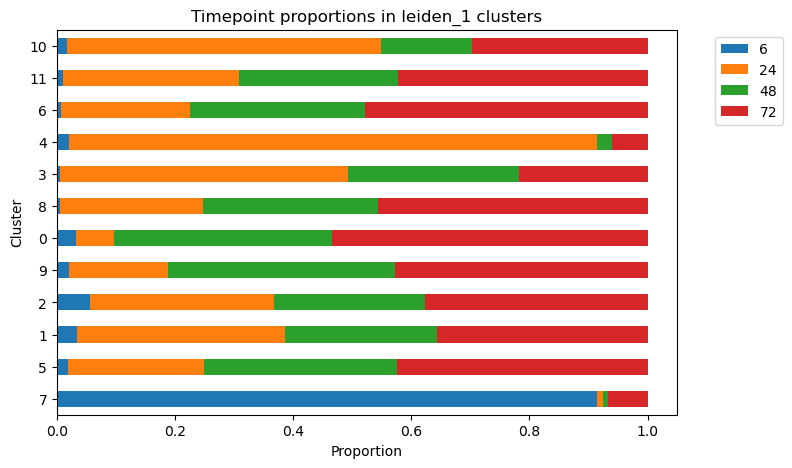

In [21]:
# Stacked barplot of timepoint proportions in leiden_1 clusters
leiden_1 = adata.obs["leiden_1"].unique().tolist()
timepoint_proportions = []
for cluster in leiden_1:
    proportions = adata.obs[adata.obs["leiden_1"] == cluster]["timepoint"].value_counts(normalize=True)
    proportions.name = cluster
    timepoint_proportions.append(proportions)
timepoint_proportions = pd.concat(timepoint_proportions, axis=1).T
timepoint_proportions = timepoint_proportions[timepoint_categories]

# Plot horizontal barplot, legend outside to right
fig, ax = plt.subplots(figsize=(8, 5))
timepoint_proportions.plot.barh(stacked=True, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Proportion")
plt.ylabel("Cluster")
plt.title("Timepoint proportions in leiden_1 clusters")

In [19]:
# pca plots
for cov in categorical_covariates + continuous_covariates:
    with plt.rc_context({'axes.facecolor':'white', 'figure.facecolor':'white'}):
        sc.pl.embedding(basis="X_spectral", adata=adata, color=[cov], show=False, components=["1,2", "3,4", "5,6", "7,8", "9,10", "11,12"], ncols=3)
        plt.savefig(os.path.join(fig_dir, f"embedding_{cov}.png"), bbox_inches="tight")
        plt.close()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite

In [22]:
adataset.close()

# DONE!

---

# Scratch